In [151]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

In [78]:
batch_size = 128
hist_win = 7
pred_win = 1

In [5]:
df = pd.read_csv('~/data/stock/full_history/GOOG.csv')
df.head()

,date,volume,open,close,high,low,adjclose
0,2019-04-18,1331800,1239.180054,1236.369995,1242.000000,1234.609985,1236.369995
1,2019-04-17,1221900,1233.000000,1236.339966,1240.560059,1227.819946,1236.339966
2,2019-04-16,856300,1225.000000,1227.130005,1230.819946,1220.119995,1227.130005
3,2019-04-15,1187400,1218.000000,1221.099976,1224.199951,1209.109985,1221.099976
4,2019-04-12,933400,1210.000000,1217.869995,1218.349976,1208.109985,1217.869995


In [133]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = df.iloc[index:x_end][self.col]
        y = df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds = StockSeqDataset(df)

dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [80]:
ds[len(ds) - 1]

(tensor([50.6754, 52.7320, 53.6063, 52.6575, 52.0962, 54.3465, 53.8050]),
 tensor([49.8458]))

In [83]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 7])
torch.Size([128, 1])


In [138]:
model = th.nn.Sequential(
    th.nn.Linear(hist_win, pred_win),
    #th.nn.ReLU(),
    #th.nn.Linear(100, pred_win),
)

loss_fn = th.nn.MSELoss()

learning_rate = 0.005
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.5))
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

for epoch in range(20):
    loss_avg = 0
    for x, y in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        #print(loss.item())
    lr_schedule.step()
    print(f'{lr_schedule.get_lr()[0]:.5f} {loss_avg / len(dl)}')

0.00405 983675.4536637932
0.00365 223321.65665409484
0.00328 6007.699459733634
0.00295 100.44157422822097
0.00266 96.92001303311052
0.00239 94.98872283409382
0.00215 98.18593584257981
0.00194 95.7564723573882
0.00174 93.0757442342824
0.00157 91.08772172599004
0.00141 94.40585616539265
0.00127 90.04364474066372
0.00114 89.36537696575296
0.00103 90.24960077219995
0.00093 87.87637631646518
0.00083 88.01971527625774
0.00075 87.25128699993265
0.00068 85.70836665712554
0.00061 86.10532984240302
0.00055 85.36666028252964


In [105]:
lr_schedule.get_lr()

[0.0005]

In [139]:
y.t()

tensor([[ 312.3435,  185.6575,  151.8325, 1226.1500,   92.3841,  625.8000,
          939.7800,  322.1100,  630.3800,  285.3888,  288.5880,  214.1273,
          235.0860,  212.3389,   63.0201,  209.5123,  538.6458,  313.0042,
          531.4733,  438.5427,  331.6132,  336.4964,  239.9444,  606.1426,
          829.0800,  298.1310,  292.1945,  587.3703,  272.4778,  189.2690,
          227.2470,  302.2094,  523.4000,  311.6828,  331.9460,  293.3371,
          175.3893,  151.0675,  298.4588,  171.8870,  229.5271,  153.9487,
          164.9273,  229.3433,  319.3330,  306.6009,  387.8275,  759.1100,
          738.6300,  146.7406,   93.0945,  606.2500,  205.4736,  216.8645,
          433.1726,  176.6858,  256.3328,  150.4962,  256.4570,  824.7300,
          172.3341,  534.0013,  307.0380,  306.2879,  304.4151,   54.3465,
          565.7504,  272.3635,  222.5525,  380.3959,  508.2056,   92.0463,
          522.3876,  261.1117,   87.9877,  301.3003,  278.1906,  139.2245,
          112.7566,  976.

In [140]:
model(x).t()

tensor([[ 318.0013,  186.2398,  152.6001, 1223.8197,   95.1647,  608.7130,
          953.8085,  317.4884,  610.6134,  277.3134,  282.9128,  190.2819,
          232.6419,  212.6899,   65.4623,  213.4482,  534.9742,  302.2319,
          540.3252,  433.3974,  334.1739,  343.6714,  233.5941,  604.0957,
          829.4048,  293.3515,  294.0325,  578.5190,  282.3569,  196.0621,
          230.6432,  301.8427,  524.9464,  309.8607,  332.1982,  294.4769,
          181.4246,  148.0206,  299.5187,  168.1765,  229.0002,  153.5936,
          187.2000,  226.1180,  319.7235,  297.4960,  389.5210,  774.4210,
          743.1615,  149.3577,   95.9916,  606.1060,  217.2412,  221.6505,
          435.7704,  174.5370,  256.9009,  150.7353,  262.1234,  824.2232,
          178.1349,  533.8087,  308.5234,  298.7771,  303.4825,   51.9180,
          565.0042,  270.0587,  221.7362,  382.8923,  516.7556,   93.9759,
          522.5367,  261.7273,   94.6846,  300.9789,  275.8995,  143.9780,
          112.9857,  974.

In [165]:
def validate(model, ticker):
    df = pd.read_csv(f'~/data/stock/full_history/{ticker}.csv')
    ds = StockSeqDataset(df)
    dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
    loss_avg = 0
    actual = []
    predicted = []
    for x, y in dl:
        actual.append(y.detach().cpu().numpy())
        optimizer.zero_grad()
        y_pred = model(x)
        predicted.append(y_pred.detach().cpu().numpy())
        loss = loss_fn(y_pred, y)
        loss_avg += loss.item()
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    print(predicted.shape)
    loss_avg /= len(dl)
    print(f'Avg loss: {loss_avg}')
    return actual, predicted, loss_avg

class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1)

def plot(predicted, actual):
    plt.figure()
    plt.plot(np.squeeze(predicted)[::-1])
    plt.plot(np.squeeze(actual)[::-1])

In [169]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0118,  0.1106,  0.0744,  0.0239, -0.0423,  0.2122,  0.6305]],
        requires_grad=True), Parameter containing:
 tensor([0.1058], requires_grad=True)]

In [161]:
actual, pred, loss_avg = validate(model, 'FB')

(1733, 1)
Avg loss: 143.97266456059046


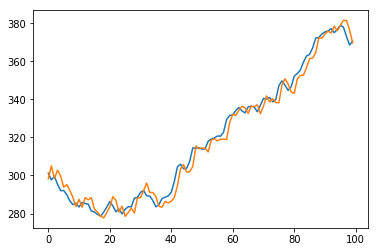

In [163]:
plot(pred[-100:], actual[-100:])

In [166]:
# Baseline
actual, pred, loss_avg = validate(MeanModel(), 'FB')

/usr/local/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(1733,)
Avg loss: 3345.666530064174


/usr/local/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [168]:
MeanModel()(th.Tensor([[1, 2, 3], [2, 4, 6]]))

tensor([2., 4.])